<a href="https://colab.research.google.com/github/sergiorolnic/datascience/blob/main/datascience_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [121]:
%matplotlib inline


In [122]:
import os.path
if not os.path.exists("train.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/sergiorolnic/datascience/main/train.csv", "train.csv")

In [123]:
train_data = pd.read_csv("train.csv", index_col=0)

# **Esplorazione Dati**

In [124]:
train_data.shape

(3000, 22)

In [125]:
train_data.head(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651


In [126]:
train_data.tail(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
3000,NaN,35000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",http://www.abductionthefilm.com/,tt1600195,en,Abduction,A young man sets out to uncover the truth abou...,10.512109,/cUT6NQP5LAJpmUoStGtXmvNt4zA.jpg,"[{'name': 'Lions Gate Films', 'id': 35}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",9/22/11,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They stole his life. He's taking it back.,Abduction,"[{'id': 591, 'name': 'cia'}, {'id': 822, 'name...","[{'cast_id': 2, 'character': 'Nathan Harper', ...","[{'credit_id': '5391990d0e0a260fb5001629', 'de...",82087155


## Significato delle colonne



*   *belongs_to_collection*: appartenenza ad una serie cinematografica
*   *budget*: costo di produzione
*   *genres*: generi
*   *homepage*: link al sito web


*   *imdb_id*: id imbd

*   *original_language*: lingua originale

*   *original_title*: titolo originale

*   *overview*: plot
*   *popularity*: popolarità
*   *poster_path*: path della locandina ufficiale
*   *production_companies*: compagnia di produzione
*   *production_countries*: paese di produzione
*   *release_date*: data di uscita
*   *runtime*: durata
*   *spoken_languages*: lingua del film
*   *status*: stato del rilascio
*   *tagline*: slogan film
*   *title*: titolo
*   *Keywords*: parole chiavi
*   *cast*: cast
*   *crew*: trop
*   *revenue*: incasso del film, variabile da predire

train_data["status"].value_counts()
train_data["genres"].str.get_dummies

train_data["genres"]= pd.DataFrame(train_data["genres"].tolist())

train_data['belongs_to_collection'].isnull().value_counts().plot.bar();

In [127]:
train_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  604 non-null    object 
 1   budget                 3000 non-null   int64  
 2   genres                 2993 non-null   object 
 3   homepage               946 non-null    object 
 4   imdb_id                3000 non-null   object 
 5   original_language      3000 non-null   object 
 6   original_title         3000 non-null   object 
 7   overview               2992 non-null   object 
 8   popularity             3000 non-null   float64
 9   poster_path            2999 non-null   object 
 10  production_companies   2844 non-null   object 
 11  production_countries   2945 non-null   object 
 12  release_date           3000 non-null   object 
 13  runtime                2998 non-null   float64
 14  spoken_languages       2980 non-null   object 
 15  stat

In [128]:
train_data.isnull().sum()

belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

Analizziamo le features individualmente ed eventualmente evidenziamo eventuali rapporti tra esse o con la target feature

 Notiamo subito che **Belongs_to_collection** e **Homepage** presentano una preponderanza di valori null. Si decide perciò di binarizzarle attraverso il quesito "Is Present" in quanto sono features che potrebbero risultare particolarmente utili durante l'addestramento.

In [129]:
train_data['belongs_to_a_collection'] = train_data['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1)
train_data = train_data.drop(columns='belongs_to_collection')

train_data['homepage_is_present'] = train_data['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)
train_data = train_data.drop(columns='homepage')



**Budget**

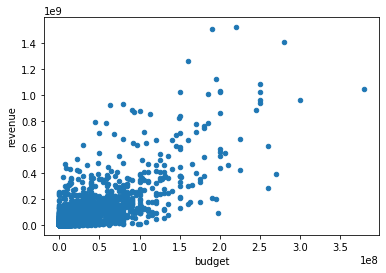

In [130]:
train_data.plot.scatter("budget", "revenue");

Si passano entrambe le features alla funzione logaritmica (log(1+x)) per meglio evidenziare il rapporto di dipendenza tra le due.



In [131]:
arr = train_data.budget > 100000
train_data = train_data[train_data.budget > 100000]

In [132]:
train_data

,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,belongs_to_a_collection,homepage_is_present
id,,,,,,,,,,,,,,,,,,,,,,
1,14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,0
2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,1,0
3,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,1
4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,1
6,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,/6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg,NaN,NaN,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993,1135654,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt0015400,en,The Thief of Bagdad,A recalcitrant thief vies with a duplicitous M...,3.878515,/a6IzXkwZRDimfn8HATzP6Pi6Ois.jpg,"[{'name': 'Douglas Fairbanks Pictures', 'id': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",3/18/24,149.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,"""Happiness Must Be Earned""",The Thief of Bagdad,"[{'id': 255, 'name': 'male nudity'}, {'id': 14...","[{'cast_id': 3, 'character': 'The Thief of Bag...","[{'credit_id': '52fe45bec3a368484e06c70b', 'de...",1213880,0,0
2994,60000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0362227,en,The Terminal,Viktor Navorski is a man without a country; hi...,14.092373,/f4Dup6awDfDqAHKgWqNJ2HFw1qN.jpg,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",6/17/04,128.0,"[{'iso_639_1': 'bg', 'name': 'български ези

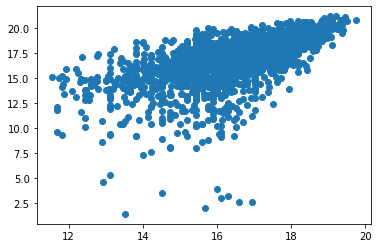

In [133]:
budget = np.log1p(train_data.budget)
revenue = np.log1p(train_data.revenue)
plt.scatter(budget, revenue)

In [134]:
np.mean((budget-budget.mean()) * (revenue-revenue.mean())) / (budget.std() * revenue.std())

0.6180524993440683

Usando la correlazione di Pearson si ottiene una correlazione modesta tra le due variabili

**Genres**

In [135]:
train_data["genres"] = (train_data['genres'].apply(lambda x: [i['name'] for i in eval(x)] if str(x) != 'nan' else []).values)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [136]:
list_of_genres = {i for x in train_data.genres for i in x}

In [137]:
for genre in list_of_genres:
  train_data["genre_" + genre] = train_data['genres'].apply(lambda x: 1 if genre in x else 0)
train_data.drop(columns='genres',inplace=True)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Per quanto riguara le features **imdb_id, 'original_title', 'status', 'poster_path'** e **title** di eliminarle in quanto poco significative

In [138]:
train_data.head(1)

,budget,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,belongs_to_a_collection,homepage_is_present,genre_Crime,genre_Music,genre_War,genre_Family,genre_Thriller,genre_Comedy,genre_Adventure,genre_Action,genre_Foreign,genre_Fantasy,genre_Documentary,genre_Romance,genre_Horror,genre_Western,genre_Animation,genre_Mystery,genre_TV Movie,genre_Drama,genre_Science Fiction,genre_History
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14000000,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [139]:
train_data.drop(columns=['imdb_id','original_title','status','poster_path', 'title'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [140]:
train_data.dtypes

budget                       int64
original_language           object
overview                    object
popularity                 float64
production_companies        object
production_countries        object
release_date                object
runtime                    float64
spoken_languages            object
tagline                     object
Keywords                    object
cast                        object
crew                        object
revenue                      int64
belongs_to_a_collection      int64
homepage_is_present          int64
genre_Crime                  int64
genre_Music                  int64
genre_War                    int64
genre_Family                 int64
genre_Thriller               int64
genre_Comedy                 int64
genre_Adventure              int64
genre_Action                 int64
genre_Foreign                int64
genre_Fantasy                int64
genre_Documentary            int64
genre_Romance                int64
genre_Horror        

**Original_language**



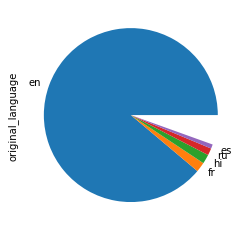

In [141]:
train_data.original_language.value_counts(normalize=True).head(5).plot.pie()


Per quanto a primo impatto potesse risultare un dato interessante, la maggior parte dei film sono in inglese, quindi risulterebbero inutili in fase di addestramento. Lo stesso ragionamento vale per **spoken_language**
Un discorso diverso invece va fatto con **popularity**. Non avendo certezza del fatto che il rating di popolarità sia antecedente alla fuoriuscita dei film, si decide cancellare la colonna assieme alle altre.

In [142]:
train_data.drop(columns= ['original_language','spoken_languages'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Keywords**

Keywords permette di determinare delle parole chiavi da associare ad ogni film, e perciò svolge lo stesso ruole di **tagline** e **overview**

In [143]:
train_data.drop(columns=['overview', 'tagline'], inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [144]:
train_data.head(1)

,budget,popularity,production_companies,production_countries,release_date,runtime,Keywords,cast,crew,revenue,belongs_to_a_collection,homepage_is_present,genre_Crime,genre_Music,genre_War,genre_Family,genre_Thriller,genre_Comedy,genre_Adventure,genre_Action,genre_Foreign,genre_Fantasy,genre_Documentary,genre_Romance,genre_Horror,genre_Western,genre_Animation,genre_Mystery,genre_TV Movie,genre_Drama,genre_Science Fiction,genre_History
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14000000,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [145]:
def cut_and_binariezed(feature,n):
  train_data[feature] = (train_data[feature].apply(lambda x: [i['name'] for i in eval(x)] if str(x) != 'nan' else []).values)
  all_values = pd.DataFrame([i for x in train_data[feature] for i in x])
  split = all_values.value_counts()[all_values.value_counts()>n]
  for keys in split.index:
      train_data[feature+" (" + keys[0]+ ")"] = train_data[feature].apply(lambda x: 1 if keys[0] in x else 0)
  train_data.drop(columns=feature,inplace=True) 


In [146]:
cut_and_binariezed("Keywords",25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Analogamente si procede allo stesso modo con **cast**,**crew**,  **production_companies** e **production_countries**

In [147]:
train_data.head(1)

,budget,popularity,production_companies,production_countries,release_date,runtime,cast,crew,revenue,belongs_to_a_collection,homepage_is_present,genre_Crime,genre_Music,genre_War,genre_Family,genre_Thriller,genre_Comedy,genre_Adventure,genre_Action,genre_Foreign,genre_Fantasy,genre_Documentary,genre_Romance,genre_Horror,genre_Western,genre_Animation,genre_Mystery,genre_TV Movie,genre_Drama,genre_Science Fiction,genre_History,Keywords (duringcreditsstinger),Keywords (woman director),Keywords (murder),Keywords (based on novel),Keywords (independent film),Keywords (violence),Keywords (dystopia),Keywords (aftercreditsstinger),Keywords (sport),Keywords (revenge),Keywords (biography),Keywords (sequel),Keywords (friendship),Keywords (suspense),Keywords (police),Keywords (sex),Keywords (teenager),Keywords (los angeles),Keywords (love),Keywords (prison),Keywords (nudity),Keywords (new york),Keywords (female nudity),Keywords (3d),Keywords (father son relationship),Keywords (drug),Keywords (musical),Keywords (high school),Keywords (based on comic),Keywords (wedding),Keywords (corruption),Keywords (alien),Keywords (family),Keywords (london england),Keywords (kidnapping),Keywords (investigation),Keywords (future),Keywords (magic),Keywords (superhero),Keywords (detective),Keywords (suicide),Keywords (remake),Keywords (escape),Keywords (serial killer),Keywords (paris),Keywords (dying and death),Keywords (brother brother relationship)
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14000000,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [148]:
cut_and_binariezed("production_companies",10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [149]:
cut_and_binariezed("production_countries",10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [150]:
cut_and_binariezed("cast",10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [151]:
cut_and_binariezed("crew",10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

**Release Date**

In [152]:
train_data[['release_month', 'release_day', 'release_year']] = train_data['release_date'].str.split('/', expand=True).astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [153]:
train_data["release_year"]=train_data['release_year'].map(lambda x: 2000 + x if x < 20 else x + 1900)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<BarContainer object of 86 artists>

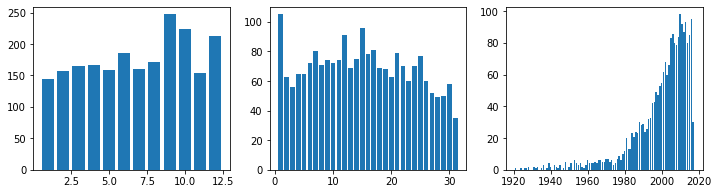

In [154]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1).bar(train_data.release_month.value_counts().index,train_data.release_month.value_counts().values)
plt.subplot(1, 3, 2).bar(train_data.release_day.value_counts().index,train_data.release_day.value_counts().values)
plt.subplot(1, 3, 3).bar(train_data.release_year.value_counts().index,train_data.release_year.value_counts().values)


In [155]:
train_data.drop(columns='release_date', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [156]:
train_data.head(1)

,budget,popularity,runtime,revenue,belongs_to_a_collection,homepage_is_present,genre_Crime,genre_Music,genre_War,genre_Family,genre_Thriller,genre_Comedy,genre_Adventure,genre_Action,genre_Foreign,genre_Fantasy,genre_Documentary,genre_Romance,genre_Horror,genre_Western,genre_Animation,genre_Mystery,genre_TV Movie,genre_Drama,genre_Science Fiction,genre_History,Keywords (duringcreditsstinger),Keywords (woman director),Keywords (murder),Keywords (based on novel),Keywords (independent film),Keywords (violence),Keywords (dystopia),Keywords (aftercreditsstinger),Keywords (sport),Keywords (revenge),Keywords (biography),Keywords (sequel),Keywords (friendship),Keywords (suspense),...,crew (Stefan Sonnenfeld),crew (Chris Lebenzon),crew (Chris David),crew (Bob Gale),crew (Duane Manwiller),crew (Joss Whedon),crew (Oliver Wood),crew (Gary Lucchesi),crew (Randy Edelman),crew (Aaron Zigman),crew (Erica Edell Phillips),crew (Steve Maslow),crew (Clint Mansell),crew (Michael Hertlein),crew (Jason Reitman),crew (Simon Kinberg),crew (Jerry Bruckheimer),crew (Harry Gregson-Williams),crew (Tim Gomillion),crew (Andrew Stanton),crew (Steve Boeddeker),crew (Felicity Bowring),crew (Steve Mann),crew (Basil Poledouris),crew (Jacques Jouffret),crew (Brett Ratner),crew (David V. Butler),crew (Lauren Shuler Donner),crew (Jeffrey Wilhoit),crew (Brian Avery),crew (Gary Rydstrom),crew (Lilly Wachowski),crew (Barry Levinson),crew (Rick Kline),crew (Sean Daniel),crew (Harry Cohen),crew (Ashok Amritraj),release_month,release_day,release_year
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14000000,6.575393,93.0,12314651,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,20,2015


In [157]:
train_data.runtime.isnull().sum()

1

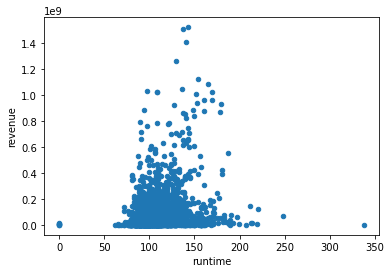

In [158]:
train_data.plot.scatter("runtime", "revenue")

# Addestramento


In [159]:
train_data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [160]:
train_data.isna().sum()

budget                     0
popularity                 0
runtime                    0
revenue                    0
belongs_to_a_collection    0
                          ..
crew (Harry Cohen)         0
crew (Ashok Amritraj)      0
release_month              0
release_day                0
release_year               0
Length: 648, dtype: int64

In [161]:
y_data = train_data.revenue
train_data.drop(columns='revenue', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [162]:
X = train_data.loc[:,["budget","popularity", "runtime"]]


In [163]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

In [164]:
# importo MSE e R²
from sklearn.metrics import mean_squared_error, r2_score

# definisco funzione per errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# funzione per calcolare e stampare tutte e tre
def print_eval(X, y, model):
    preds = model.predict(X)
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(relative_error(y, preds)))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

In [165]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=4, kernel="poly", degree=2))
])
from sklearn.model_selection import cross_validate
cv_result = cross_validate(model, X, y_data, cv=kf, return_train_score=True)
cv_result

{'fit_time': array([0.18093228, 0.18913174, 0.16630149, 0.18557739, 0.21424437]),
 'score_time': array([0.01251316, 0.01341534, 0.0063169 , 0.00657892, 0.01233864]),
 'test_score': array([0.63380922, 0.54825721, 0.68360326, 0.54843382, 0.62582155]),
 'train_score': array([0.62244183, 0.64150302, 0.61066091, 0.64317433, 0.6274438 ])}

In [166]:
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)


In [167]:
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(train_data, y_data):
        X_train, y_train = train_data.iloc[train_indices], y_data.iloc[train_indices]
        X_val, y_val = train_data.iloc[val_indices], y_data.iloc[val_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv)
        gs.fit(X_train, y_train)
        score = gs.score(X_val, y_val)
        results.append(score)
    return results

model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(kernel="poly"))
])
grid = {
    "regr__degree": range(2, 11),
    "regr__alpha": [0.01, 0.1, 1, 10],
}
nested_cv(model, grid)

In [168]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
    train_test_split(X, y_data, test_size=1/3, random_state=42)

In [169]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=4, random_state=42)
model.fit(X_train, y_train);

In [170]:
model.score(X_train, y_train)

0.7107649417838349

In [171]:
print_eval(X_train, y_train, model)

   Mean squared error: 7.0853e+15
       Relative error: 417631.01119%
R-squared coefficient: 0.71076


In [172]:
print_eval(X_val, y_val, model)

   Mean squared error: 1.0603e+16
       Relative error: 2673470.64915%
R-squared coefficient: 0.56672


In [173]:
model.score(X_val, y_val)

0.5667164969352054

In [174]:
model = DecisionTreeRegressor(min_samples_split=0.4, random_state=42)
model.fit(X_train, y_train);

In [175]:
model.score(X_train, y_train)

0.5492348323558296

In [176]:
model.score(X_val, y_val)

0.48409403585288713

In [177]:
model = DecisionTreeRegressor(random_state=42)
grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 0.02, 0.05, 0.1]
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 5, 'min_samples_split': 0.05}

In [178]:
gs.score(X_val, y_val)

0.5255838996071589

In [179]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(
    hidden_layer_sizes=[4],
    activation="relu",
    solver="sgd",
    random_state=12345
)

In [180]:
model.fit(X_train, y_train);

In [181]:
model.score(X_val, y_val)

-1.4606539581190723e+45

In [182]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [183]:
model = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [184]:
model.fit(X_train, y_train, batch_size=100, epochs=5)


Epoch 1/5
15/15 [==============================] - 0s 2ms/step - loss: 25716711537770496.0000
Epoch 2/5
15/15 [==============================] - 0s 2ms/step - loss: 23204286666113024.0000
Epoch 3/5
15/15 [==============================] - 0s 2ms/step - loss: 20740388482449408.0000
Epoch 4/5
15/15 [==============================] - 0s 2ms/step - loss: 18717080928911360.0000
Epoch 5/5
15/15 [==============================] - 0s 2ms/step - loss: 16656911818555392.0000


In [185]:
model = Sequential([
    Dense(512, activation="relu", input_dim=X_train.shape[1]),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [186]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
15/15 [==============================] - 0s 2ms/step - loss: 28153491297927168.0000
Epoch 2/5
15/15 [==============================] - 0s 2ms/step - loss: 18955556840538112.0000
Epoch 3/5
15/15 [==============================] - 0s 2ms/step - loss: 11372634239401984.0000
Epoch 4/5
15/15 [==============================] - 0s 3ms/step - loss: 10740176682745856.0000
Epoch 5/5
15/15 [==============================] - 0s 2ms/step - loss: 10591305600073728.0000


In [187]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    Dense(128, activation="relu", kernel_regularizer=l2(0.001), input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [188]:
model.fit(X_train, y_train, batch_size=100, epochs=50)

Epoch 1/50
15/15 [==============================] - 0s 2ms/step - loss: 30775951084224512.0000
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 28290144272384000.0000
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 25807247300886528.0000
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 23466445027409920.0000
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 21063200371900416.0000
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 18748837917097984.0000
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 16428281045712896.0000
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 14620413346709504.0000
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 13064054637592576.0000
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 11968732750413824.0000
Epoch 11/50
15/15 [==============================

In [189]:
X_train.head(1)

,budget,popularity,runtime
id,,,
2658,13000000,3.960622,94.0
